<div align="right">Naoaki ONO, Shigehiko KANAYA <br/>
NAIST DSC</div>

# はじめてのCNN

深層学習が世に広まるきっかけとなった画像認識に使われている畳み込みニューラルネットワーク(Convolutional Neural Networks)を実際に使ってみましょう。

In [1]:
import numpy as np
import tensorflow as tf
import cv2

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


## MNIST
深層学習の入門用としてすっかり有名になった<a href="https://en.wikipedia.org/wiki/MNIST_database">MNIST</a>データセットを使って、手書き文字の画像認識を学習してみましょう。
<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></img>

In [2]:
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()

nc = 10         # classify hand-written 10 digits [0-9]
nx, ny = 28, 28 # image size

11493376/11490434 [==============================] - 0s 0us/step


このデータセットでは28ピクセル四方のグレイスケール画像の輝度が入力データとして与えられています。これを28x28 = 784次元の値と考えて学習させることも一応可能ですが、その場合、画像上でのピクセルの位置関係などが意味を持たなくなってしまいます。

画像上の各ピクセルの近傍の情報を足し合わせて、線分や境界の特徴を取り出すために用いられるのが畳み込み演算と呼ばれる計算手法です。

畳み込み演算の一般的な形は次のような式で与えられます。フィルターと呼ばれる重み係数を$w(\mathbf{r})$として、入力となる$g(\mathbf{x})$に掛けて足し合わせた（積分した）ものを考えます。フィルターをかける位置が移動しながら入力に掛け合わされていきます。

$$
h(\mathbf{x}) = \int w (\mathbf{r}) g(\mathbf{x}+\mathbf{r})d\mathbf{r}
$$

画像の場合はピクセルごとの計算になるので、次のような和の形になります。

$$
h (i,j) = \sum_{i'}\sum_{j'} W({i,'j'}) g(i+i', j+j') 
$$

実際の画像で計算する例を以下の図に示します。


![A sckematic illustration of convolution](https://github.com/naono-git/colaboratory/raw/master/figure_1/convolution1.gif)

入力の画像のうち黄色で囲った部分のピクセル（黒を1、白を0と考えて下さい）に、3x3の重み行列を掛けて合計した値を計算します。一番左上の場合は真ん中の二つのピクセルに1が掛けられるので合計は2となります。

フィルターの位置に合わせてそれぞれ合計した値を並べることで、重みをかけられた$h(i,j)$の出力が（特徴マップ）が得られます。この出力はもとの画像の中のどこに「縦に並んだピクセル」があったかという特徴を反映した出力になっています。

フィルターとして掛け合わせる行列の値を変えれば、縦に並んだピクセル以外にも様々な形状を特徴マップとして定量化することができます。実際には値は01に限りませんし、フィルターのサイズをもっと大きくすることも、またRGBなど色の情報を足し合わせることもできます。

画像認識では様々な種類のフィルターを適用して、もとの画像から縦線や横線、縞々や目玉模様など、さまざまなパーツを抽出し、定量化することで画像の分類に必要な情報を集めます。しかし、どのような種類のフィルターに着目すれ精度よく画像が分類できるか、は、与えられた問題によって異なるため、あらかじめたくさんのフィルターを用意しておくことは必ずしも効率がよくありません。

畳み込みニューラルネットワーク(Convolutional Neural Netowrks: CNN)ではこの重み行列をニューラルネットワークの係数と考えて学習によって最適化することで、必要な特徴を効率よく抽出することができるため、既存の方法と比べて良い成績が得られるようになったと考えられています。

さらに一般のCNNでは、この出力された特徴マップにさらに畳み込みを行い、何段階も繰り返します。特徴の合成を繰り返すことで文字や数字、人の顔といった複雑なパターンをマップとして抽出することができるようになります。


（注）この図での黄色の枠は元画像からはみ出ないように動かしていますが、そのため出力のマップが元画像より小さくなってしまっています。
元画像の隅から隅までフィルターを適用するために、はみ出した部分をすべて`0`と考えて(余白を埋める、という意味でpaddingといいます)畳み込みを行う方法もよく使われます。

### データ整形

学習を簡単にするため、画像のピクセル値を[0,1]の実数に、教師データとなるの0~9までの数字の分類を、対応する数字のところだけが1、あとは0として表される10次元のベクトル（one-hotベクトルと呼ばれます）に変換します。
$$
\begin{eqnarray*}
0 &\Rightarrow& (1,0,0, \dots, 0)\\
1 &\Rightarrow& (0,1,0, \dots, 0)\\
&\vdots& \\
9 &\Rightarrow& (0,0,0, \dots, 1)\\
\end{eqnarray*}
$$

In [0]:
x_trn = x_train_org.astype('float32').reshape(x_train_org.shape[0], ny, nx, 1)/255
x_tst = x_test_org.astype('float32').reshape(x_test_org.shape[0], ny, nx, 1)/255

In [0]:
y_trn = keras.utils.to_categorical(y_train_org, nc)
y_tst = keras.utils.to_categorical(y_test_org, nc)

ネットワークを構築します。

レイヤーオブジェクトとして2次元畳み込みを行う`Conv2D`を使っている以外はあまり変わっていません。

特徴マップを計算するために二回畳み込みを行なっています。

（注）そのまま畳み込みを行うと、特徴マップが増えるたびに出力ノードの数が増えていってしまい、最終的に分類を計算するのが難しくなります。ここではマップを計算する位置を一つ飛ばしにすることでデータを間引いています。マップを計算した後でサイズを縮小する「プーリング」という方法を使う場合もあります。

2段階目の特徴マップから32ノードの中間層への全結合ネットワークを経て最終的に10ノードの出力が得られるようになっています。

10ノードのうち値が一番大きいものが予測された文字になります。

In [7]:
model1 = Sequential()
model1.add(Conv2D(8, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape=(ny, nx, 1), padding="same", name='conv1'))
model1.add(Conv2D(16, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding="same", name='conv2'))
model1.add(Flatten(name='flatten') )
model1.add(Dense(32, activation='relu', name='dense1'))
model1.add(Dense(10, activation='softmax', name='dense2'))
model1.summary()
model1.compile(loss=keras.losses.categorical_crossentropy,
             optimizer='adagrad',
             metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 8)         208       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 16)          3216      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                25120     
_________________________________________________________________
dense2 (Dense)               (None, 10)                330       
Total params: 28,874
Trainable params: 28,874
Non-trainable params: 0
_________________________________________________________________


### 学習

とりあえず10ステップほど学習させてみましょう。

In [8]:
nb = 128 # batch size
ne = 12  # number of epochs

hist1 = model1.fit(x_trn, y_trn,
         batch_size=nb,
         epochs=ne,
         verbose=0,
         validation_data=(x_tst, y_tst))

Instructions for updating:
Use tf.cast instead.


最終的な正解率を確認します。

In [9]:
model1.evaluate(x_tst, y_tst, verbose=0)

[0.0483023442681646, 0.9842]

99%程度の正解率なら、まあまあうまく学習できたと言えるでしょう。

学習の過程をプロットしてみます。

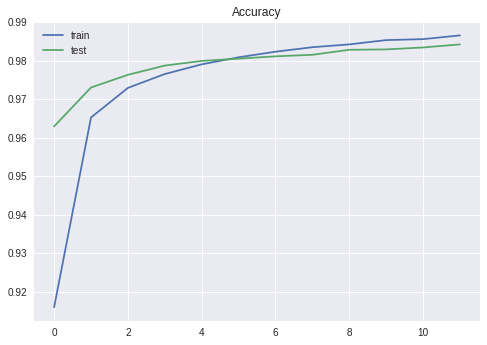

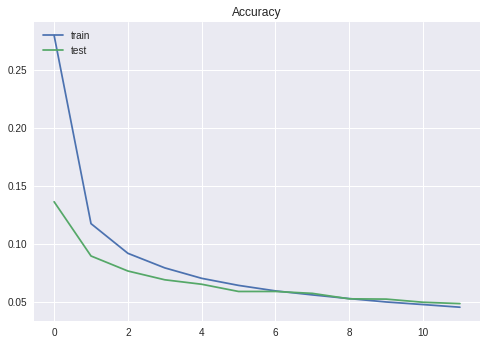

In [10]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

学習のステップ数をもっと長く取れば、もうすこし精度が良くなるかもしれません。
が、まあ良くなったとしても微妙な差でしょうか。

### ハイパーパラメータ

一次元の回帰の場合と同様、どのようなネットワーク、どのような学習パラメータなら最適な結果が得られるか、やってみないとわからないところが多々あります。

ネットワークの深さやフィルターの数などをいろいろ変えて、学習の精度や効率の変化を試してみましょう。

## Grad-CAM

CNNによる学習の結果は、単なる回帰などと違ってどのように情報が処理されているか、途中経過を見てもいささかわかりにくいという難点があります。

「深層学習はなんだか優秀そうだが、ブラックボックス化してしまって何故それが学習できているのか説明できない」という批判もしばしば聞かれます。

とはいえ近年では学習結果を分析するための手法もいろいろ提案されてきています。
ここでは学習結果を可視化するアプローチの一つとしてGradient-weighted Class Activation Mapping (Grad-CAM)を紹介します。

たとえば一つ目のテストサンプルの画像に対して、その画像のどの領域が分類に影響を及ぼしたか、逆算してみましょう。

とりあえずサンプルとして使う画像を、テストデータの1枚目とします（他のサンプルを見たいときは`aa`の値を適宜変えてください）。

In [0]:
sess = K.get_session()

aa = 12
x_tmp = x_tst[(aa-1):(aa),:]
y_tmp = y_test_org[aa-1]
pred_tmp = model1.predict(x_tmp)
y_pred = np.argmax(pred_tmp[0])

教師ラベルが`y_tmp`、分類された数字が`y_pred`です。
画像と合っていたでしょうか。

org= 6 pred= 6


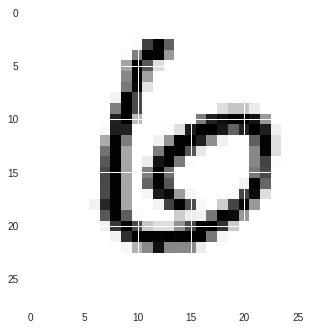

In [40]:
print("org=", y_tmp,"pred=",y_pred)
dumb = plt.imshow(x_tmp[0,:,:,0])

畳み込みレイヤーの出力を抽出して、その重みが答えの予測にどれだけ影響を受けていたかを調べます。

答えの出力ノードは10個ありますが、ここではとりあえず予測したラベルに対応する、一番出力の値の大きかった出力ノードに対する影響の大きさを調べることにします。

正しく判定できていたにしても、答えが間違ていたにしても、ニューラルネットワークが画像のどこを見て判断したか調べることができると期待されます。

`K.gradients()`で答えの出力ノードの値に対しての`last_conv_layer`の微分を計算します。
畳み込みレイヤーから出力された特徴マップの各ノードから答えの出力にあたえる影響の係数を得たことになります。

In [0]:
last_conv_layer = model1.layers[1]

out_tmp = model1.output[:, y_pred]

grad_tmp = K.gradients(out_tmp, last_conv_layer.output)[0]


今回のモデルでは`last_conv_layer`の出力は、一つ一つのマップが7x7サイズの出力ノードを持つ16枚の特徴マップになっています。

まず、いささか大雑把ですが、各マップごとに7x7の全部の係数の値を平均して、各マップごとの影響力を評価してみることにします。

In [0]:
pooled_grad = K.mean(grad_tmp, axis=(0, 1, 2))
get_grad = K.function([model1.input], [pooled_grad, last_conv_layer.output[0]])


In [0]:
pooled_grad_value,  last_conv_layer_output_value = get_grad([x_tmp])

In [44]:
last_conv_layer_output_value.shape

(7, 7, 16)

<BarContainer object of 16 artists>

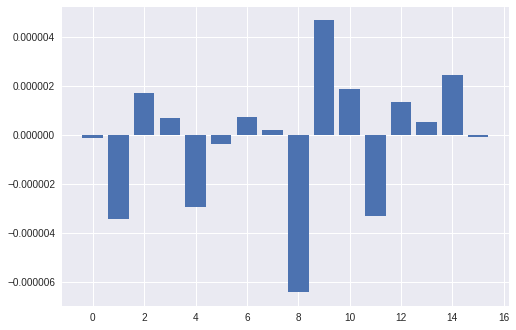

In [45]:
plt.bar(np.arange(16),pooled_grad_value)

ざっくばらんに言えば、この係数の絶対値が大きな特徴マップほど、最終的な数字の分類に大きく寄与したと言えそうです。

とりあえず一番影響の大きそうな特徴マップの出力をみてみましょう。

In [46]:
ii = np.argmax(np.abs(pooled_grad_value))
print(ii)

8


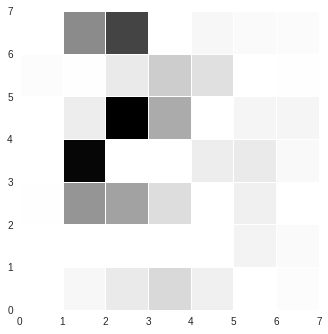

In [47]:
dumb = plt.imshow(last_conv_layer_output_value[:, :, ii],extent=[0,7,0,7])

黒いところほど値が大きいことを表しています。


...元画像の線分か曲線か、なにかの特徴に対応するマップのはずですが、どんな特徴かわかるでしょうか？

正直、6枚全部を見比べてもなかなか解釈は難しいと思われます。
それぞれの特徴マップが違ったパターンを抽出しているはずなのですが、ひとつひとつ個別に画像との対応を比較するのは大変です。


そこで、各マップに先ほど求めたマップごとの重みの平均をかけた上で、16枚の特徴マップを全部足し合わせてみましょう。

In [0]:
heatmap = last_conv_layer_output_value[:,:,0]*0

for ii in range(16):
        heatmap += last_conv_layer_output_value[:, :, ii]*pooled_grad_value[ii]

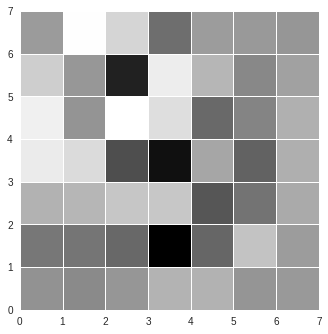

In [57]:
dumb = plt.imshow(heatmap,extent=[0,7,0,7])

なんとなく文字の印象が見えてきたでしょうか。

色をつけて、もと画像に重ね合わせてみます。

In [0]:

img_src = cv2.cvtColor(np.uint8(x_tmp[0,:,:,0]*255), cv2.COLOR_GRAY2RGB)

tmp0 = np.maximum(heatmap, 0)
tmp0 /= np.max(heatmap)
tmp0 = cv2.resize(tmp0, (ny, nx))
img_heatmap = cv2.applyColorMap(np.uint8(tmp0*255), cv2.COLORMAP_JET)
img_gcam = cv2.addWeighted(img_src, 0.6, img_heatmap, 0.4, 0)


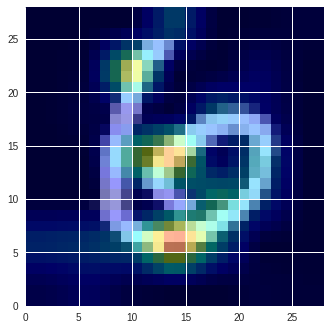

In [59]:
pix_tmp = cv2.cvtColor(img_gcam, cv2.COLOR_BGR2RGB)
dumb = plt.imshow(pix_tmp, extent=[0,28,0,28])

色々な特徴を総合した結果、赤く表示された領域における画像の特徴が、この画像の判定にもっとも寄与している、のだそうです。

それっぽい領域が赤く強調されているでしょうか。

### Guided back-prop

Grad-CAM では着目した特徴のある"領域"を強調しましたが、着目した特徴の形状を再構成しようとする方法としてはguided-back-propagationという手法が提案されています。

計算の都合上、先ほど構築したCNNから、各層の重み変数を一旦取り出します。

In [0]:

hoge = model1.layers[0]
fuga = hoge.weights
W_conv1 = sess.run(fuga[0])
b_conv1 = sess.run(fuga[1])
hoge = model1.layers[1]
fuga = hoge.weights
W_conv2 = sess.run(fuga[0])
b_conv2 = sess.run(fuga[1])

hoge = model1.layers[3]
fuga = hoge.weights
W_dense1 = sess.run(fuga[0])
b_dense1 = sess.run(fuga[1])

hoge = model1.layers[4]
fuga = hoge.weights
W_dense2 = sess.run(fuga[0])
b_dense2 = sess.run(fuga[1])


例えばテストデータの`aa=1`番目の画像について、元画像で着目された特徴がどのようなものか見てみましょう。
（画像を変えたい場合は`aa`の値を変えて試してみてください）

In [0]:
aa = 12
x_tmp = x_tst[(aa-1):aa]


特徴の逆算のため、先ほど抽出した重みの値を元に、同じネットワークを一旦再構築します。

In [0]:

x_input = tf.placeholder(tf.float32, shape=[1, 28, 28, 1])

# Convolutional Layer #1
l_conv1 =  tf.nn.relu(tf.nn.conv2d(x_input,          W_conv1, strides=[1, 2, 2, 1], padding='SAME')+b_conv1)
l_conv2 =  tf.nn.relu(tf.nn.conv2d(l_conv1, W_conv2, strides=[1, 2, 2, 1], padding='SAME') + b_conv2)
l_flatten = tf.reshape(l_conv2, [-1, 7*7*16])
l_dense1 = tf.nn.relu(tf.matmul(l_flatten, W_dense1) + b_dense1)
l_dense2 = tf.matmul(l_dense1, W_dense2) + b_dense2
l_output = tf.nn.softmax(l_dense2)


さきほどと同様、10個の出力ノードのうち、正解の数字に対応する出力ノードに着目し、そこから逆算していくものとします。

`y_tmp`は正解のノードだけを1とするone-hotベクトルになりますので、outputレイヤーの出力にこのベクトルとを掛けると他の要素が全て0になるため、逆算から無視できます。

他の出力ノードから逆算したい場合は違う要素を1とするベクトルをかけてみてください。

In [0]:
y_tmp = tf.reshape(y_tst[aa-1],(10,1))
l_probability = tf.matmul(l_output, y_tmp)


最終的なoutputレイヤーの出力に対する上流レイヤーの影響を微分によって連鎖的に求めていきます。

In [0]:
l_gradient = tf.gradients(l_probability, x_input)
grad_dense2 = tf.nn.relu(tf.gradients(l_probability, l_dense2)[0])
grad_dense1 = tf.nn.relu(tf.gradients(l_dense2, l_dense1, grad_ys=grad_dense2)[0])
grad_conv2 = tf.nn.relu(tf.gradients(l_dense1, l_conv2, grad_ys=grad_dense1)[0])
grad_conv1 = tf.nn.relu(tf.gradients(l_conv2, l_conv1, grad_ys=grad_conv2)[0])
grad_x = tf.nn.relu(tf.gradients(l_conv1, x_input, grad_ys=grad_conv1)[0])


得られた「影響力」マップを元の画像と比べてみましょう。

（サリエンシー(saliency)は卓越性などと訳されることもありますが、ここでは"目を引く度合い"ぐらいの意味で、心理学や脳科学では画像や音の刺激が"どれぐらい注意を引きやすい"かの指標によく使われる名前です）

org= 6


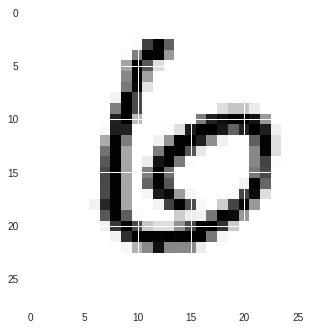

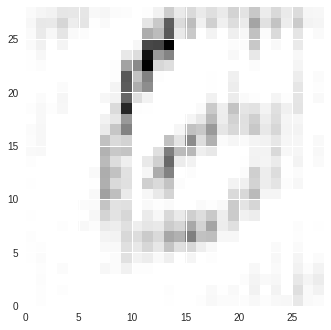

In [65]:
x_saliency = sess.run(grad_x, feed_dict={x_input: x_tmp})[0].reshape(28,28)
print("org=", y_test_org[aa-1])
plt.figure(1)
dumb = plt.imshow(x_tmp[0,:,:,0])
plt.figure(2)
plt.imshow(x_saliency, extent=[0,28,0,28])
plt.show()


区別に寄与した特徴が強調されているでしょうか。

数字の認識の課題の場合、あまり無視できる情報は含まれていないので差がわかりにくいかもしれませんが、一般の写真などの画像認識の課題だと、背景に対して被写体に着目している様子などが強調されるようです。

興味があれば入力画像をいろいろ変えて結果を比べてみてください。